# scratch work

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from scipy.optimize import least_squares, minimize

from jorbit import Observations, Particle
from jorbit.astrometry.transformations import icrs_to_horizons_ecliptic
from jorbit.utils.states import CartesianState, KeplerianState


In [2]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)


obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

[Text(0.5, 0, 'RA'), Text(0, 0.5, 'DEC')]

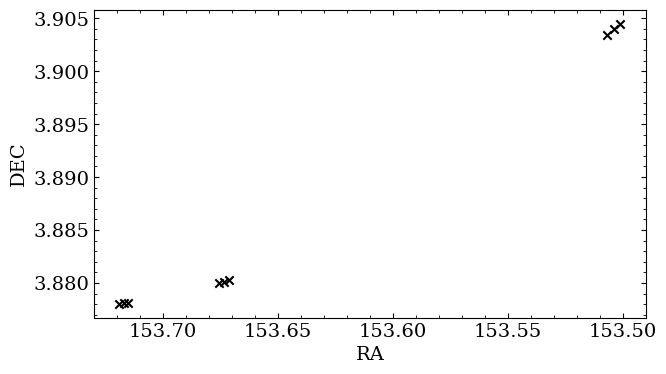

In [3]:
fig, ax = plt.subplots()
ax.scatter(coords.ra, coords.dec, c="k", marker="x")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set(xlabel="RA", ylabel="DEC")

In [4]:
obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)
obs

Observations with 9 set(s) of observations

In [5]:
obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
true_x0, true_v0

(Array([-2.00572335,  1.77860137,  0.5197407 ], dtype=float64),
 Array([-0.00665991, -0.00662871, -0.00203885], dtype=float64))

In [6]:
p0 = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
)
p0

Particle: 274301 Wikipedia

In [7]:
print(p0.cartesian_state)
print(p0.keplerian_state)

CartesianState(x=Array([[-2.00572335,  1.77860137,  0.5197407 ]], dtype=float64), v=Array([[-0.00665991, -0.00662871, -0.00203885]], dtype=float64), time=np.float64(2460676.792467407))
KeplerianState(semi=Array([2.37859645], dtype=float64), ecc=Array([0.14924503], dtype=float64), inc=Array([6.73363769], dtype=float64), Omega=Array([183.37295038], dtype=float64), omega=Array([140.26385356], dtype=float64), nu=Array([173.65462829], dtype=float64), time=np.float64(2460676.792467407))


In [8]:
p1 = p0.max_likelihood()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           50

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33487D+10    |proj g|=  1.44601D+11


 This problem is unconstrained.



At iterate    1    f=  1.05423D+10    |proj g|=  2.36925D+10

At iterate    2    f=  8.37602D+09    |proj g|=  2.05286D+10

At iterate    3    f=  3.29099D+09    |proj g|=  1.55430D+10

At iterate    4    f=  5.86065D+08    |proj g|=  7.02731D+09

At iterate    5    f=  2.00478D+07    |proj g|=  2.13931D+09

At iterate    6    f=  2.00002D+06    |proj g|=  8.68628D+08

At iterate    7    f=  2.67625D+05    |proj g|=  2.39249D+08

At iterate    8    f=  2.03301D+04    |proj g|=  4.63480D+07

At iterate    9    f=  3.45317D+03    |proj g|=  4.58154D+05

At iterate   10    f=  3.44927D+03    |proj g|=  3.12814D+05

At iterate   11    f=  3.44748D+03    |proj g|=  5.20120D+04

At iterate   12    f=  3.44743D+03    |proj g|=  2.45289D+04

At iterate   13    f=  3.44742D+03    |proj g|=  2.47594D+04

At iterate   14    f=  3.44734D+03    |proj g|=  5.53064D+04

At iterate   15    f=  3.44717D+03    |proj g|=  1.11200D+05

At iterate   16    f=  3.44668D+03    |proj g|=  2.07102D+05

At iter

In [9]:
p1.residuals(jnp.concatenate([p1._x, p1._v]))

Array([[-4.53942769e-07, -1.02186033e-06],
       [-3.98357920e-07,  1.04323482e-06],
       [ 7.87147816e-07,  5.25321435e-07],
       [ 2.72539265e-07, -7.25119919e-07],
       [-4.97797634e-07,  6.35748338e-07],
       [-3.48837977e-07,  4.05752313e-08],
       [-2.87035437e-07, -9.92434556e-07],
       [ 9.18807844e-07,  6.32994255e-07],
       [-5.26095001e-07,  1.24681087e-07]], dtype=float64)

In [9]:
def generate_initial_keplerian(ra, dec):
    phi = ra
    theta = jnp.pi / 2 - dec

    x = jnp.sin(theta) * jnp.cos(phi)
    y = jnp.sin(theta) * jnp.sin(phi)
    z = jnp.cos(theta)

    x_icrs = jnp.hstack([x, y, z])
    x = icrs_to_horizons_ecliptic(x_icrs)

    # assume we're observing the thing at its highest excursion from the ecliptic:
    inc = jnp.abs(jnp.arcsin(x[2])) / jnp.linalg.norm(x) * 180 / jnp.pi

    # its longitude of ascending node is the angle between the x-axis and the projection of the vector onto the xy-plane:
    varphi = (jnp.arctan2(x[1], x[0]) * 180 / jnp.pi) % 360
    Omega = varphi - 90 if x[2] > 0 else varphi + 90

    nu = 90.0 if x[2] > 0 else 270.0
    a = 3.0
    ecc = 0.0
    omega = 0.0

    return jnp.array([a, ecc, nu, inc, Omega, omega])

def keplerian_objective(x):
    k = KeplerianState(
            semi=x[0:1],
            ecc=x[1:2],
            nu=x[2:3],
            inc=x[3:4],
            Omega=x[4:5],
            omega=x[5:6],
            time=times[0],
        )
    c = k.to_cartesian()
    x = jnp.concatenate([c.x.flatten(), c.v.flatten()])
    return -p0.loglike(x)

keplerian_objective(generate_initial_keplerian(p0._observations.ra[0], p0._observations.dec[0]))

jax.grad(keplerian_objective)(generate_initial_keplerian(p0._observations.ra[0], p0._observations.dec[0]))

Array([-1.74874229e+10,  3.01094918e+08,  2.76083138e+09,  2.41128669e+08,
        2.74309763e+09,  2.76083138e+09], dtype=float64)

In [31]:
def keplerian_objective(x):
    k = KeplerianState(
            semi=x[0:1],
            ecc=x[1:2],
            nu=x[2:3],
            inc=x[3:4],
            Omega=x[4:5],
            omega=x[5:6],
            time=times[0],
        )
    c = k.to_cartesian()
    x = jnp.concatenate([c.x.flatten(), c.v.flatten()])
    r = p0.residuals(x)
    return jnp.linalg.norm(r, axis=1)

keplerian_objective(generate_initial_keplerian(p0._observations.ra[0], p0._observations.dec[0]))

res = least_squares(
    fun=keplerian_objective,
    x0=generate_initial_keplerian(p0._observations.ra[0], p0._observations.dec[0]),
    verbose=2,
    method="lm",
)
res

KeyboardInterrupt: 

In [12]:
def keplerian_objective(x):
    k = KeplerianState(
            semi=x[0:1],
            ecc=x[1:2],
            nu=x[2:3],
            inc=x[3:4],
            Omega=x[4:5],
            omega=x[5:6],
            time=times[0],
        )
    c = k.to_cartesian()
    x = jnp.concatenate([c.x.flatten(), c.v.flatten()])
    r = p0.residuals(x)
    return jnp.linalg.norm(r, axis=1)

res = least_squares(
    fun=keplerian_objective,
    jac=jax.jacfwd(keplerian_objective),
    x0=generate_initial_keplerian(p0._observations.ra[0], p0._observations.dec[0]),
    verbose=2,
)
res

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0803e+10                                    1.75e+10    
       1              2         4.7208e+09      1.61e+10       3.64e+02       3.18e+10    
       2              4         7.0212e+08      4.02e+09       1.08e+02       6.61e+09    
       3              8         8.2983e+07      6.19e+08       1.18e+00       2.63e+09    
       4             10         4.3101e+05      8.26e+07       5.88e-01       1.61e+08    
       5             13         4.8339e+04      3.83e+05       7.35e-02       1.54e+07    
       6             18         4.4935e+04      3.40e+03       5.74e-04       4.69e+06    
       7             20         4.4571e+04      3.65e+02       1.44e-04       3.75e+05    
       8             21         4.4562e+04      9.05e+00       1.44e-04       1.80e+06    
       9             22         4.4510e+04      5.21e+01       3.59e-05       5.83e+05    

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.040e+02  1.017e+02  9.926e+01  4.706e+01  4.468e+01
                4.228e+01  1.258e+02  1.282e+02  1.307e+02]
           x: [ 2.550e+00  1.663e-01  1.963e+02  1.013e+01  5.282e+02
               -2.260e+02]
        cost: 43176.221262296895
         jac: [[-4.693e+03 -9.579e+03 ...  2.269e+02 -4.938e+02]
               [-4.658e+03 -9.505e+03 ...  2.213e+02 -4.996e+02]
               ...
               [ 4.807e+03  9.557e+03 ... -2.619e+02  4.789e+02]
               [ 4.747e+03  9.429e+03 ... -2.525e+02  4.886e+02]]
        grad: [ 9.513e+04  1.096e+05 -8.231e+04  1.238e+05 -5.003e+04
               -8.194e+04]
  optimality: 123754.6547348428
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00]
        nfev: 287
        njev: 273

In [16]:
res.x

array([ 2.55043707e+00,  1.66256623e-01,  1.96267115e+02,  1.01308640e+01,
        5.28163642e+02, -2.26048969e+02])

In [15]:
p0.keplerian_state

KeplerianState(semi=Array([2.37859645], dtype=float64), ecc=Array([0.14924503], dtype=float64), inc=Array([6.73363769], dtype=float64), Omega=Array([183.37295038], dtype=float64), omega=Array([140.26385356], dtype=float64), nu=Array([173.65462829], dtype=float64), time=np.float64(2460676.792467407))

In [8]:
import copy

perturbed = copy.deepcopy(p0.cartesian_state)
perturbed.x += 1000 * u.km.to(u.au)
ll = p0.loglike(jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()]))
ll

Array(-22.57306906, dtype=float64)

In [9]:
p0.residuals(jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()]))

Array([[-0.90962391,  0.69842047],
       [-0.90984353,  0.69858176],
       [-0.91006152,  0.69873977],
       [-0.91479967,  0.70217721],
       [-0.9150206 ,  0.70233721],
       [-0.91524007,  0.70249453],
       [-0.93037155,  0.71334351],
       [-0.93059056,  0.71350114],
       [-0.93081201,  0.71365595]], dtype=float64)

In [10]:
from scipy.optimize import least_squares

x0 = jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()])
x1 = jnp.concatenate([-perturbed.x.flatten(), perturbed.v.flatten()])

In [11]:
p0.residuals(x0), p0.residuals(x1)

(Array([[-0.90962391,  0.69842047],
        [-0.90984353,  0.69858176],
        [-0.91006152,  0.69873977],
        [-0.91479967,  0.70217721],
        [-0.9150206 ,  0.70233721],
        [-0.91524007,  0.70249453],
        [-0.93037155,  0.71334351],
        [-0.93059056,  0.71350114],
        [-0.93081201,  0.71365595]], dtype=float64),
 Array([[-91092.82616836,  44300.54791232],
        [-91067.48832186,  44293.03170153],
        [-91041.82333691,  44285.50912264],
        [-90499.66732878,  44118.36499448],
        [-90472.91765956,  44110.15553629],
        [-90445.84779392,  44101.94104199],
        [-88523.61709689,  43472.6618289 ],
        [-88492.77544129,  43462.40902278],
        [-88461.63551964,  43452.15541053]], dtype=float64))

In [14]:
def f(x):
    return -p0.loglike(x)


result = minimize(
    fun=f,
    x0=x1,
    method="Nelder-Mead",
    options={"disp": True, "maxiter": 1000},
)
p0.loglike(result.x)

Optimization terminated successfully.
         Current function value: 3188.938457
         Iterations: 439
         Function evaluations: 713


Array(-3188.9384567, dtype=float64)

In [17]:
def tmp(x):
    r = p0.residuals(x)
    return jnp.linalg.norm(r, axis=1)


result = least_squares(
    fun=tmp,
    x0=x1,
    verbose=2,
    method="lm",
)
p0.loglike(result.x)

`xtol` termination condition is satisfied.
Function evaluations 558, initial cost 4.5159e+10, final cost 2.8194e+03, first-order optimality 7.82e+03.


Array(-2835.97158603, dtype=float64)

In [20]:
result = least_squares(
    fun=tmp,
    # jac=gradient,
    x0=x1,
    verbose=2,
)
p0.loglike(result.x)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5159e+10                                    8.19e+10    
       1              3         8.4716e+09      3.67e+10       6.83e-01       1.40e+10    
       2              4         8.2194e+09      2.52e+08       1.37e+00       1.90e+10    
       3              5         2.6552e+09      5.56e+09       3.41e-01       8.10e+09    
       4              6         4.2061e+07      2.61e+09       6.83e-01       1.18e+09    
       5              8         1.8053e+07      2.40e+07       5.42e-02       1.66e+09    
       6              9         7.1703e+05      1.73e+07       5.42e-02       2.57e+08    
       7             12         8.3191e+04      6.34e+05       6.77e-03       1.16e+08    
       8             15         2.0467e+04      6.27e+04       8.46e-04       3.10e+07    
       9             16         1.3565e+04      6.90e+03       1.69e-03       3.76e+07    

KeyboardInterrupt: 

In [11]:
jax.jacfwd(p0.loglike)(jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()]))

Array([ -415941.92979457,  -739901.15981344,  -648959.72258677,
        -721214.59992895, -1277773.22303356, -1121110.99923105],      dtype=float64)

In [12]:
jax.grad(p0.loglike)(jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()]))

ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop with dynamic start/stop values. Try using lax.scan, or using fori_loop with static start/stop.

In [13]:
from scipy.optimize import minimize

x0 = jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()])


@jax.jit
def objective(x):
    return -p0.loglike(x)


@jax.jit
def gradient(x):
    return -jax.jacfwd(p0.loglike)(x)


def scale_decorator(func, gradient_func, x0):
    # Determine parameter scales based on initial values
    param_scales = jnp.where(jnp.abs(x0) < 1e-10, 1.0, jnp.abs(x0))

    # Compute gradient at initial point to determine gradient scales
    initial_grad = gradient_func(x0)
    grad_scales = jnp.where(jnp.abs(initial_grad) < 1e-10, 1.0, jnp.abs(initial_grad))

    def scaled_func(x_scaled):
        x_unscaled = x_scaled * param_scales
        return func(x_unscaled)

    def scaled_gradient(x_scaled):
        x_unscaled = x_scaled * param_scales
        raw_gradient = gradient_func(x_unscaled)
        return (raw_gradient * param_scales) / grad_scales

    x0_scaled = x0 / param_scales

    def unscale_result(result):
        """Helper to unscale optimization result"""
        unscaled_result = result
        unscaled_result.x = result.x * param_scales
        unscaled_result.jac = result.jac * grad_scales / param_scales
        return unscaled_result

    return (
        scaled_func,
        scaled_gradient,
        x0_scaled,
        unscale_result,
        param_scales,
        grad_scales,
    )


# Usage example:
scaled_obj, scaled_grad, x0_scaled, unscale_result, param_scales, grad_scales = (
    scale_decorator(objective, gradient, x0)
)

# Run optimizer with scaled functions
result = minimize(
    fun=scaled_obj,
    x0=x0_scaled,
    jac=scaled_grad,
    method="BFGS",
    options={
        "disp": True,
        "ftol": 1e-8,
        "gtol": 1e-8,
    },
)

# Unscale the result
final_result = unscale_result(result)

# result = minimize(
#     fun=scaled_obj,
#     x0=scaled_x0,
#     jac=scaled_grad,
#     method='L-BFGS-B',
#     options={"disp": True, "ftol": 1e-8, "gtol": 1e-8,},
# )

/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_23957/1719285525.py:47: OptimizeWarning: Unknown solver options: ftol
  result = minimize(


         Current function value: 16.556969
         Iterations: 4
         Function evaluations: 123
         Gradient evaluations: 111


/Users/cassese/Documents/virtual_envs/jorbit/lib/python3.13/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [14]:
# Run optimizer with scaled functions
result = minimize(
    fun=scaled_obj,
    x0=x0_scaled,
    jac=scaled_grad,
    method="L-BFGS-B",
    options={
        "disp": True,
        "maxls": 100,  # Increase max line search steps (default is 20)
        "maxcor": 30,  # Increase memory storage (default is 10)
        "ftol": 1e-12,  # Make function value convergence more lenient
        "gtol": 1e-8,  # Gradient convergence criterion
        "maxfun": 5000,  # Increase max function evaluations
        "maxiter": 1000,  # Increase max iterations
        "eps": 1e-10,  # Step size for finite difference (if needed)
        "line_search": "strong_wolfe",  # Use strong Wolfe conditions
    },
)

# Unscale the result
final_result = unscale_result(result)

/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_23957/1958235744.py:2: OptimizeWarning: Unknown solver options: line_search
  result = minimize(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           30

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25731D+01    |proj g|=  2.00572D+00


 This problem is unconstrained.



At iterate    1    f=  1.88198D+01    |proj g|=  8.44737D-01

At iterate    2    f=  1.79691D+01    |proj g|=  4.14018D-01

At iterate    3    f=  1.76637D+01    |proj g|=  3.67542D-01

At iterate    4    f=  1.68003D+01    |proj g|=  4.31605D-01

At iterate    5    f=  1.65988D+01    |proj g|=  2.21770D-01

At iterate    6    f=  1.65458D+01    |proj g|=  2.39457D-02

At iterate    7    f=  1.65413D+01    |proj g|=  1.41109D-02

At iterate    8    f=  1.65409D+01    |proj g|=  2.58912D-03

At iterate    9    f=  1.65409D+01    |proj g|=  4.25874D-04

At iterate   10    f=  1.65409D+01    |proj g|=  1.07829D-04

At iterate   11    f=  1.65409D+01    |proj g|=  1.68624D-05

At iterate   12    f=  1.65409D+01    |proj g|=  1.34610D-05

At iterate   13    f=  1.65409D+01    |proj g|=  2.09287D-04
  ys=-9.005E-14  -gs= 1.468E-13 BFGS update SKIPPED

At iterate   14    f=  1.65409D+01    |proj g|=  4.41940D-05

At iterate   15    f=  1.65409D+01    |proj g|=  4.18094D-05

At iterate   16  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [15]:
from scipy.optimize import least_squares

result = least_squares(
    fun=scaled_obj,
    # jac=scaled_grad,
    x0=x0_scaled,
    verbose=2,
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5477e+02                                    2.97e+07    
       1             11         2.1755e+02      3.72e+01       9.34e-06       2.48e+07    
       2             12         1.7156e+02      4.60e+01       2.34e-06       1.03e+07    
       3             13         1.6787e+02      3.69e+00       4.67e-06       1.13e+07    
       4             14         1.5527e+02      1.26e+01       1.17e-06       5.48e+06    
       5             15         1.4912e+02      6.16e+00       2.34e-06       4.27e+06    
       6             16         1.4661e+02      2.51e+00       2.34e-06       4.82e+06    
       7             17         1.4370e+02      2.91e+00       5.84e-07       2.32e+06    
       8             18         1.4163e+02      2.07e+00       1.17e-06       1.97e+06    
       9             19         1.4023e+02      1.41e+00       1.17e-06       1.84e+06    

In [16]:
x = unscale_result(result).x
c = CartesianState(x=x[:3][None, :], v=x[3:][None, :], time=times[0])
c.to_keplerian()

KeplerianState(semi=Array([2.37860178], dtype=float64), ecc=Array([0.14924396], dtype=float64), inc=Array([6.73363883], dtype=float64), Omega=Array([183.37296835], dtype=float64), omega=Array([140.26403582], dtype=float64), nu=Array([173.65444973], dtype=float64), time=<Time object: scale='utc' format='jd' value=2460676.791666667>)

In [17]:
result.x

Array([-2.00572658,  1.77860293,  0.51974103, -0.00665991, -0.00662871,
       -0.00203885], dtype=float64)

In [19]:
scaled_obj(x0_scaled), objective(
    result.x
)  # why is least_squares returning something unscaled?

(Array(22.57306906, dtype=float64), Array(16.54132464, dtype=float64))

In [20]:
from scipy.optimize import least_squares

result = least_squares(
    fun=objective,
    # jac=scaled_grad,
    x0=x0,
    verbose=2,
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5477e+02                                    2.88e+07    
       1             12         1.8042e+02      7.43e+01       2.60e-06       7.60e+06    
       2             13         1.7088e+02      9.54e+00       2.60e-06       9.89e+06    
       3             14         1.6386e+02      7.02e+00       2.60e-06       7.29e+06    
       4             15         1.5672e+02      7.14e+00       6.51e-07       4.85e+06    
       5             16         1.5155e+02      5.17e+00       1.30e-06       3.86e+06    
       6             17         1.4793e+02      3.62e+00       1.30e-06       3.63e+06    
       7             18         1.4540e+02      2.53e+00       1.30e-06       4.47e+06    
       8             19         1.4372e+02      1.68e+00       1.30e-06       3.37e+06    
       9             20         1.4201e+02      1.71e+00       3.26e-07       2.39e+06    

In [21]:
result.x

array([-2.00572091,  1.77860035,  0.51974064, -0.00665998, -0.00662872,
       -0.00203887])

In [22]:
from scipy.optimize import least_squares

result = least_squares(
    fun=objective,
    jac=gradient,
    x0=x0,
    verbose=2,
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5477e+02                                    2.88e+07    
       1             12         1.8045e+02      7.43e+01       2.60e-06       7.59e+06    
       2             13         1.7114e+02      9.31e+00       2.60e-06       9.91e+06    
       3             14         1.6391e+02      7.24e+00       2.60e-06       7.30e+06    
       4             15         1.5681e+02      7.09e+00       6.51e-07       4.83e+06    
       5             16         1.5172e+02      5.09e+00       1.30e-06       3.86e+06    
       6             17         1.4803e+02      3.69e+00       1.30e-06       3.62e+06    
       7             18         1.4557e+02      2.46e+00       1.30e-06       4.47e+06    
       8             19         1.4379e+02      1.78e+00       1.30e-06       3.38e+06    
       9             20         1.4210e+02      1.69e+00       3.26e-07       2.38e+06    

In [23]:
objective(result.x)

Array(16.54218454, dtype=float64)

In [45]:
scaled_obj(result.x)

Array(2.05587732e+09, dtype=float64)

In [12]:
import optimistix


# def func(x, args):
#     c = CartesianState(x=x[:3][None,:], v=x[3:][None,:], time=times[0].tdb.jd)
#     return -p0.loglike(c)
def func(x, args):
    return -p0.loglike(x)


solver = optimistix.BFGS(
    rtol=1e-12,
    atol=1e-12,
    verbose=frozenset({"step_size", "loss", "y"}),
    use_inverse=False,
)
res = optimistix.minimise(
    fn=func,
    solver=solver,
    y0=jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()]),
)

Loss on this step: 22.573069057682215, Loss on the last accepted step: 0.0, Step size: 1.0, y: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885], y on the last accepted step: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885]
Loss on this step: 2.0616324795378832e+17, Loss on the last accepted step: 22.573069057682215, Step size: 0.5, y: [ -415943.93551124  -739899.38120539  -648959.20283939  -721214.60658886
 -1277773.22966227 -1121111.00126991], y on the last accepted step: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885]
Loss on this step: 2.061641537689634e+17, Loss on the last accepted step: 22.573069057682215, Step size: 0.25, y: [-207972.97061395 -369948.80129867 -324479.341546   -360607.30662438
 -638886.61814549 -560555.50165438], y on the last accepted step: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885]
Loss on this step: 2.0616596534629104e+17, Loss on the last accepted step: 

In [13]:
def func(x, args):
    return -p0.loglike(x)


solver = optimistix.BFGS(
    rtol=1e-12,
    atol=1e-12,
    verbose=frozenset({"step_size", "loss", "y"}),
    use_inverse=True,
)
res = optimistix.minimise(
    fn=func,
    solver=solver,
    y0=jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()]),
)

Loss on this step: 22.573069057682215, Loss on the last accepted step: 0.0, Step size: 1.0, y: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885], y on the last accepted step: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885]
Loss on this step: 2.0616324795378832e+17, Loss on the last accepted step: 22.573069057682215, Step size: 0.5, y: [ -415943.93551124  -739899.38120539  -648959.20283939  -721214.60658886
 -1277773.22966227 -1121111.00126991], y on the last accepted step: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885]
Loss on this step: 2.061641537689634e+17, Loss on the last accepted step: 22.573069057682215, Step size: 0.25, y: [-207972.97061395 -369948.80129867 -324479.341546   -360607.30662438
 -638886.61814549 -560555.50165438], y on the last accepted step: [-2.00571666  1.77860805  0.51974738 -0.00665991 -0.00662871 -0.00203885]
Loss on this step: 2.0616596534629104e+17, Loss on the last accepted step: 

[None]

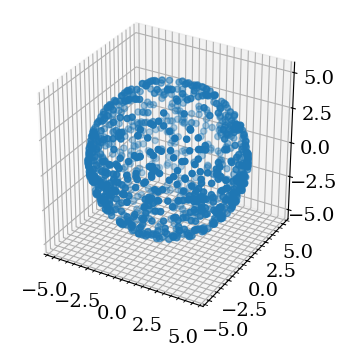

In [72]:
import numpy as np

Omegas = jnp.linspace(0, 2 * jnp.pi, 11)[:-1] * 180 / jnp.pi
incs = jnp.arccos(jnp.linspace(-1, 1, 11))[:-1] * 180 / jnp.pi
# nus = jnp.linspace(0, 2 * jnp.pi, 11)[:-1] * 180 / jnp.pi
# nus = jnp.array([jnp.pi/4, 7*jnp.pi/4]) * 180 / jnp.pi
# Omegas = jnp.array([0.0]) * 180 / jnp.pi
incs = jnp.linspace(0, jnp.pi, 11)[:-1] * 180 / jnp.pi

arrs = []
for Omega in Omegas:
    for inc in incs:
        for _nu in range(10):
            arrs.append(
                jnp.array([5.0, 0.0, np.random.uniform(0, 360), inc, Omega, 0.0])
            )
arrs = jnp.array(arrs)

k = KeplerianState(
    semi=arrs[:, 0],
    ecc=arrs[:, 1],
    nu=arrs[:, 2],
    inc=arrs[:, 3],
    Omega=arrs[:, 4],
    omega=arrs[:, 5],
    time=times[0],
)
c = k.to_cartesian()
x = icrs_to_horizons_ecliptic(c.x)
v = icrs_to_horizons_ecliptic(c.v)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x[:, 0], x[:, 1], x[:, 2])
ax.set(aspect="equal")

# phi = Omegas * jnp.pi / 180
# theta = incs * jnp.pi / 180
# x = jnp.outer(jnp.sin(theta), jnp.cos(phi))
# y = jnp.outer(jnp.sin(theta), jnp.sin(phi))
# z = jnp.outer(jnp.cos(theta), jnp.ones_like(phi))
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(x, y, z, alpha=0.5)
# ax.set(aspect="equal")

In [73]:
x = jnp.hstack([x, v])
r = jax.vmap(p0.loglike)(x)

In [74]:
r = jax.vmap(p0.loglike)(x)

In [77]:
r.max()

Array(-10947237.04957968, dtype=float64)

In [79]:
from tqdm import tqdm

j = np.zeros(len(r))
for i, c in tqdm(enumerate(x)):
    j[i] = p0.loglike(c)

1000it [00:29, 33.37it/s]


In [239]:
# phi = p0._observations.ra[0]
# theta = jnp.pi/2 - p0._observations.dec[0]

i = 2
j = 3
phi = jnp.linspace(0, 2 * jnp.pi, 10)[i]
theta = jnp.pi / 2 - jnp.linspace(-jnp.pi, jnp.pi, 10)[j]


x = jnp.sin(theta) * jnp.cos(phi)
y = jnp.sin(theta) * jnp.sin(phi)
z = jnp.cos(theta)


x_icrs = jnp.hstack([x, y, z])
x = icrs_to_horizons_ecliptic(x_icrs)  # * 3.0


# assume we're observing the thing at its highest excursion from the ecliptic:
inc = jnp.array([jnp.abs(jnp.arcsin(x[2])) / jnp.linalg.norm(x) * 180 / jnp.pi])

# its longitude of ascending node is the angle between the x-axis and the projection of the vector onto the xy-plane:
varphi = (jnp.arctan2(x[1], x[0]) * 180 / jnp.pi) % 360
Omega = jnp.array([varphi]) - 90 if x[2] > 0 else jnp.array([varphi]) + 90

nu = jnp.array([90.0]) if x[2] > 0 else jnp.array([270.0])
a = jnp.array([3.0])
ecc = jnp.array([0.0])
omega = jnp.array([0.0])

k = KeplerianState(
    semi=a, ecc=ecc, nu=nu, inc=inc, Omega=Omega, omega=omega, time=times[0]
)
c = k.to_cartesian()
c.x / 3.0, x_icrs

(Array([[ 0.08682409,  0.49240388, -0.8660254 ]], dtype=float64),
 Array([ 0.08682409,  0.49240388, -0.8660254 ], dtype=float64))

In [240]:
def generate_initial_guess(ra, dec):
    phi = ra
    theta = jnp.pi / 2 - dec

    x = jnp.sin(theta) * jnp.cos(phi)
    y = jnp.sin(theta) * jnp.sin(phi)
    z = jnp.cos(theta)

    x_icrs = jnp.hstack([x, y, z])
    x = icrs_to_horizons_ecliptic(x_icrs)

    # assume we're observing the thing at its highest excursion from the ecliptic:
    inc = jnp.array([jnp.abs(jnp.arcsin(x[2])) / jnp.linalg.norm(x) * 180 / jnp.pi])

    # its longitude of ascending node is the angle between the x-axis and the projection of the vector onto the xy-plane:
    varphi = (jnp.arctan2(x[1], x[0]) * 180 / jnp.pi) % 360
    Omega = jnp.array([varphi]) - 90 if x[2] > 0 else jnp.array([varphi]) + 90

    nu = jnp.array([90.0]) if x[2] > 0 else jnp.array([270.0])
    a = jnp.array([3.0])
    ecc = jnp.array([0.0])
    omega = jnp.array([0.0])

    k = KeplerianState(
        semi=a, ecc=ecc, nu=nu, inc=inc, Omega=Omega, omega=omega, time=times[0]
    )
    c = k.to_cartesian()

    return jnp.concatenate([c.x.flatten(), c.v.flatten()])


generate_initial_guess(p0._observations.ra[0], p0._observations.dec[0])

Array([-2.68373692,  1.32528782,  0.20289981, -0.00432348, -0.00821017,
       -0.00355955], dtype=float64)

In [242]:
x0 = generate_initial_guess(p0._observations.ra[0], p0._observations.dec[0])


def tmp(x):
    r = p0.residuals(x)
    return jnp.linalg.norm(r, axis=1)


result = least_squares(
    fun=tmp,
    x0=x0,
    verbose=2,
    method="lm",
)

result = least_squares(
    fun=tmp,
    x0=result.x,
    verbose=2,
)
p0.loglike(result.x)

`xtol` termination condition is satisfied.
Function evaluations 267, initial cost 2.0803e+10, final cost 2.0829e+01, first-order optimality 2.81e+05.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0829e+01                                    1.51e+03    
       1             13         2.0829e+01      1.08e-05       2.01e-08       2.17e+03    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 2.0829e+01, final cost 2.0829e+01, first-order optimality 2.17e+03.


Array(-37.37021373, dtype=float64)

In [244]:
x0, perturbed.x.flatten()

(Array([-2.68373692,  1.32528782,  0.20289981, -0.00432348, -0.00821017,
        -0.00355955], dtype=float64),
 Array([-2.00571666,  1.77860805,  0.51974738], dtype=float64))

In [247]:
p0.residuals(x0), p0.residuals(
    jnp.concatenate([perturbed.x.flatten(), perturbed.v.flatten()])
)

(Array([[ 60350.47697017, -29348.02941075],
        [ 60368.24178112, -29360.07765625],
        [ 60386.01812898, -29372.11240986],
        [ 60771.72808604, -29636.19788502],
        [ 60789.75940909, -29648.39425987],
        [ 60807.80023077, -29660.57633796],
        [ 62072.27698179, -30521.56535972],
        [ 62091.07246654, -30534.19213625],
        [ 62109.87083723, -30546.80199541]], dtype=float64),
 Array([[-0.90962391,  0.69842047],
        [-0.90984353,  0.69858176],
        [-0.91006152,  0.69873977],
        [-0.91479967,  0.70217721],
        [-0.9150206 ,  0.70233721],
        [-0.91524007,  0.70249453],
        [-0.93037155,  0.71334351],
        [-0.93059056,  0.71350114],
        [-0.93081201,  0.71365595]], dtype=float64))

In [249]:
x0 = generate_initial_guess(p0._observations.ra[0], p0._observations.dec[0])

result = minimize(
    fun=lambda x: -p0.loglike(x),
    x0=x0,
    jac=lambda x: -jax.grad(p0.loglike)(x),
    method="L-BFGS-B",
    options={
        "disp": True,
        "maxls": 100,  # Increase max line search steps (default is 20)
        "maxcor": 30,  # Increase memory storage (default is 10)
        "ftol": 1e-12,  # Make function value convergence more lenient
        "gtol": 1e-8,  # Gradient convergence criterion
        "maxfun": 5000,  # Increase max function evaluations
        "maxiter": 1000,  # Increase max iterations
        "eps": 1e-10,  # Step size for finite difference (if needed)
        "line_search": "strong_wolfe",  # Use strong Wolfe conditions
    },
)

/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_32615/2677624643.py:3: OptimizeWarning: Unknown solver options: line_search
  result = minimize(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           30

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08026D+10    |proj g|=  8.59172D+10


 This problem is unconstrained.



At iterate    1    f=  6.87312D+09    |proj g|=  1.34391D+10

At iterate    2    f=  5.63142D+09    |proj g|=  1.38511D+10

At iterate    3    f=  1.72328D+09    |proj g|=  9.57667D+09

At iterate    4    f=  2.10574D+08    |proj g|=  4.36231D+09

At iterate    5    f=  6.43936D+06    |proj g|=  1.21037D+09

At iterate    6    f=  5.98118D+05    |proj g|=  4.08164D+08

At iterate    7    f=  3.49487D+04    |proj g|=  3.54526D+07

At iterate    8    f=  2.50987D+03    |proj g|=  4.57711D+06

At iterate    9    f=  2.08509D+03    |proj g|=  2.21285D+06

At iterate   10    f=  2.07084D+03    |proj g|=  1.35289D+05

At iterate   11    f=  2.07047D+03    |proj g|=  1.19648D+05

At iterate   12    f=  2.07010D+03    |proj g|=  2.10923D+04

At iterate   13    f=  2.07008D+03    |proj g|=  1.55474D+04

At iterate   14    f=  2.07006D+03    |proj g|=  1.51741D+04

At iterate   15    f=  2.06996D+03    |proj g|=  4.51527D+04

At iterate   16    f=  2.06976D+03    |proj g|=  8.84213D+04

At iter

In [250]:
x0 = generate_initial_guess(p0._observations.ra[0], p0._observations.dec[0])

result = minimize(
    fun=lambda x: -p0.loglike(x),
    x0=x0,
    # jac=lambda x: -jax.grad(p0.loglike)(x),
    method="L-BFGS-B",
    options={
        "disp": True,
        "maxls": 100,  # Increase max line search steps (default is 20)
        "maxcor": 30,  # Increase memory storage (default is 10)
        "ftol": 1e-12,  # Make function value convergence more lenient
        "gtol": 1e-8,  # Gradient convergence criterion
        "maxfun": 5000,  # Increase max function evaluations
        "maxiter": 1000,  # Increase max iterations
        "eps": 1e-10,  # Step size for finite difference (if needed)
        "line_search": "strong_wolfe",  # Use strong Wolfe conditions
    },
)

/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_32615/2864640065.py:3: OptimizeWarning: Unknown solver options: line_search
  result = minimize(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           30

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08026D+10    |proj g|=  8.59169D+10


 This problem is unconstrained.



At iterate    1    f=  6.79468D+09    |proj g|=  1.64232D+10

At iterate    2    f=  2.49217D+09    |proj g|=  8.37510D+09

At iterate    3    f=  1.49127D+08    |proj g|=  3.43455D+09

At iterate    4    f=  3.86313D+07    |proj g|=  3.16180D+09

At iterate    5    f=  6.95561D+06    |proj g|=  1.00851D+09

At iterate    6    f=  2.78564D+04    |proj g|=  6.61831D+07

At iterate    7    f=  9.26132D+03    |proj g|=  1.68038D+07

At iterate    8    f=  6.74918D+03    |proj g|=  1.10810D+07

At iterate    9    f=  4.78945D+03    |proj g|=  7.49951D+06

At iterate   10    f=  3.72583D+03    |proj g|=  4.72473D+06

At iterate   11    f=  3.56047D+03    |proj g|=  5.15348D+05

At iterate   12    f=  3.55960D+03    |proj g|=  7.46747D+04

At iterate   13    f=  3.55958D+03    |proj g|=  1.17105D+05

At iterate   14    f=  3.55956D+03    |proj g|=  6.12807D+04

At iterate   15    f=  3.55953D+03    |proj g|=  1.14185D+05

At iterate   16    f=  3.55953D+03    |proj g|=  2.18137D+04

At iter

KeyboardInterrupt: 